# Testing with different probabilities in the loop
for this let's take 100 terms and run it via mixed strategy of LO & RI

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append("../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import *
from calculus.generation_threading import *

from calculus_utils.drawing import *
from calculus_utils.algorithms import *
from calculus_utils.outliers_cleaning import clear_arr

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=100)
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]
stepsRand = [
    sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT))
    / RANDOM_AVERAGE_COUNT
    for term in tqdm(terms)
]

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


In [3]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = [
        sum(
            [
                term.normalize(
                    MixedStrategy(
                        [LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p
                    )
                )[1]
                for i in range(RANDOM_AVERAGE_COUNT)
            ]
        )
        / RANDOM_AVERAGE_COUNT
        for term in tqdm(terms, desc=f"it {inx} / {iters}")
    ]
    steps_mixed_all.append(steps)

it 20 / 20: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 32.60it/s]


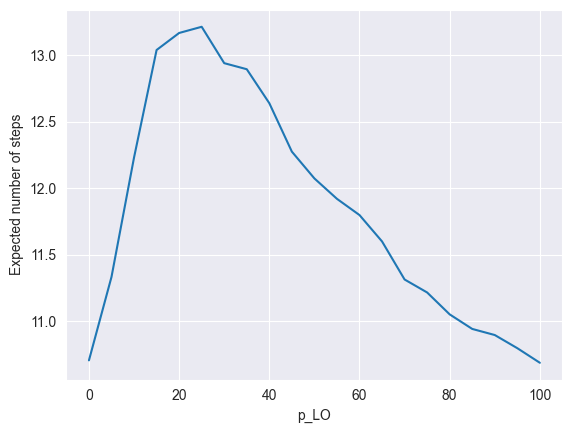

In [4]:
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma**2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.show()

In [7]:
inx_best = expected_values.index(min(expected_values))

In [8]:
print(inx_best)

20


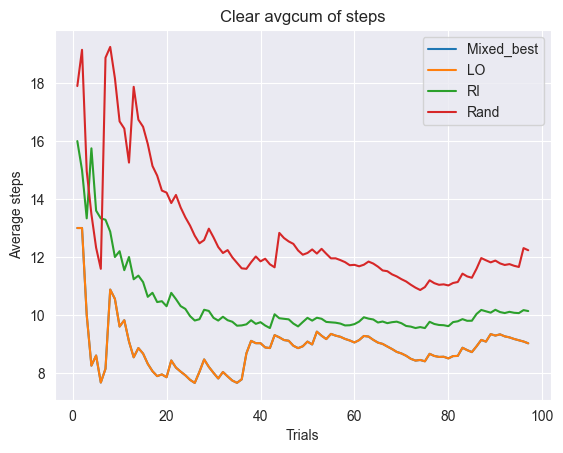

In [10]:
comp_data = {
    "Mixed_best": (clear_arr(steps_mixed_all[inx_best]), "-"),
    "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")

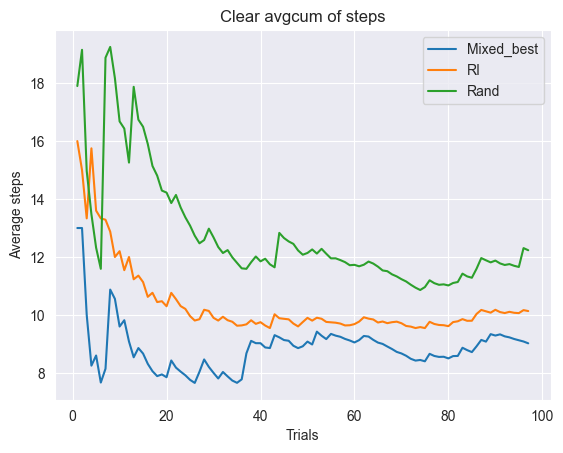

In [11]:
comp_data = {
    "Mixed_best": (clear_arr(steps_mixed_all[inx_best]), "-"),
    # "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")

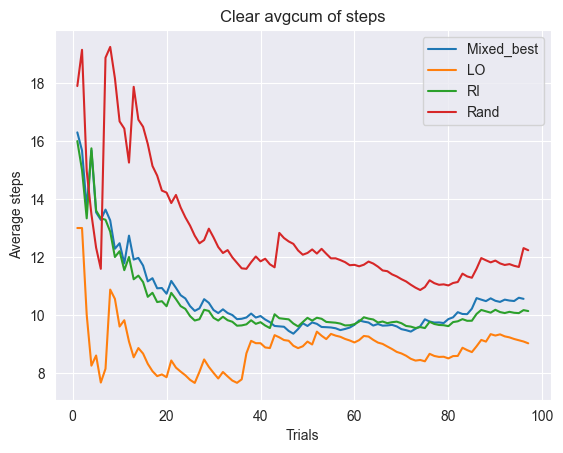

In [15]:
comp_data = {
    "Mixed_best": (clear_arr(steps_mixed_all[1]), "-"),
    "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")

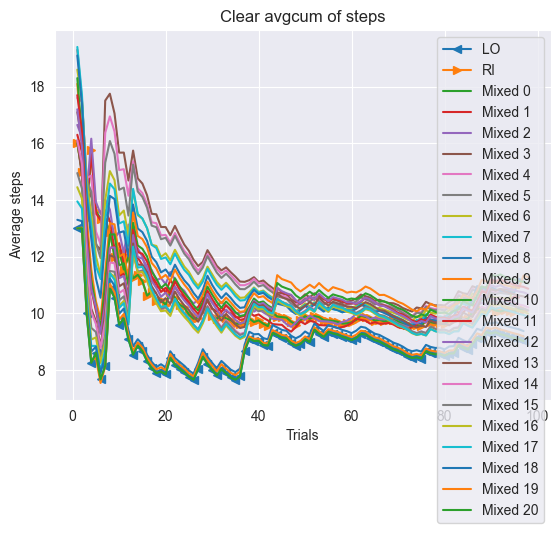

In [18]:
comp_data = {
    "LO": (clear_arr(stepsLO), "-<"),
    "RI": (clear_arr(stepsRI), "->"),
}

for inx, steps in enumerate(steps_mixed_all):
    comp_data[f"Mixed {inx}"] = (clear_arr(steps), "-")


draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")